In [1]:
# Import libraries

import numpy as np
import pickle
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, regularizers
# from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

from tensorflow import keras 
!pip install -q -U keras-tuner 
import keras_tuner 
from keras_tuner import RandomSearch

In [2]:
# Loading pickles 

def load_color_inputs():
    X_train_realsense = pickle.load(open('X_train_realsense.pkl', "rb"))
    X_val_realsense = pickle.load(open('X_val_realsense.pkl', "rb"))
    X_test_realsense = pickle.load(open('X_test_realsense.pkl', "rb"))
    return X_train_realsense, X_val_realsense, X_test_realsense

X_train_realsense, X_val_realsense, X_test_realsense = load_color_inputs()

def load_outputs():
    Y_train_realsense = pickle.load(open('Y_train_realsense.pkl', "rb"))
    Y_val_realsense = pickle.load(open('Y_val_realsense.pkl', "rb"))
    Y_test_realsense = pickle.load(open('Y_test_realsense.pkl', "rb"))
    return Y_train_realsense, Y_val_realsense, Y_test_realsense

Y_train_realsense, Y_val_realsense, Y_test_realsense = load_outputs()

Y_train_realsense = np.argmax(Y_train_realsense, axis=-1)
Y_val_realsense = np.argmax(Y_val_realsense, axis=-1)

In [3]:
def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    
    for i in range(hp.Int('layers', 2, 4)): # Searching through for 2, 3 and 4 hidden layers
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units_' + str(i), 32, 512, step=32), # Searching for optimal amount of nodes per hidden layer from 32 to 512 with step size of 32
            activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid']))) # Searching for optimal activation method
    model.add(tf.keras.layers.Dense(210, activation='softmax')) # Output layer is kept out of the for loop because that is fixed
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                     values=[1e-2, 1e-3, 1e-4])), # Learning Rate of 0.01, 0.001 and 0.0001
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model  

tuner = RandomSearch(
    build_model,
    objective='val_accuracy', # Objective is to maximize validation accuracy
    max_trials=5, # Trial 5 times
    executions_per_trial=3,
    overwrite=True
    )

tuner.search_space_summary()

tuner.search(X_train_realsense, Y_train_realsense, 
             epochs=50, 
             validation_data=(X_val_realsense, Y_val_realsense))

tuner.results_summary()

# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(64, 64, 3))
best_model.summary()

print(Y_train_realsense.shape) 

Trial 5 Complete [00h 04m 39s]
val_accuracy: 0.9949206312497457

Best val_accuracy So Far: 0.9949206312497457
Total elapsed time: 00h 20m 48s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 3
units_0: 160
act_0: relu
units_1: 192
act_1: relu
learning_rate: 0.0001
units_2: 320
act_2: relu
units_3: 352
act_3: sigmoid
Score: 0.9949206312497457
Trial summary
Hyperparameters:
layers: 3
units_0: 96
act_0: sigmoid
units_1: 32
act_1: sigmoid
learning_rate: 0.0001
units_2: 288
act_2: relu
Score: 0.9933333396911621
Trial summary
Hyperparameters:
layers: 3
units_0: 448
act_0: relu
units_1: 352
act_1: relu
learning_rate: 0.01
units_2: 32
act_2: relu
Score: 0.004761904943734407
Trial summary
Hyperparameters:
layers: 3
units_0: 416
act_0: sigmoid
units_1: 256
act_1: sigmoid
learning_rate: 0.01
units_2: 32
act_2: sigmoid
Score: 0.004761904943734407
Trial summary
Hyperparameters:
layers: 4
units_0: 416
ac

Epoch 1/20
138/138 [==============================] - 2s 8ms/step - loss: 0.3753 - accuracy: 0.8971 - val_loss: 0.1645 - val_accuracy: 0.9467
Epoch 2/20
138/138 [==============================] - 1s 6ms/step - loss: 0.2424 - accuracy: 0.9298 - val_loss: 0.1570 - val_accuracy: 0.9537
Epoch 3/20
138/138 [==============================] - 1s 6ms/step - loss: 0.1754 - accuracy: 0.9467 - val_loss: 0.1050 - val_accuracy: 0.9708
Epoch 4/20
138/138 [==============================] - 1s 6ms/step - loss: 0.1629 - accuracy: 0.9495 - val_loss: 0.0746 - val_accuracy: 0.9771
Epoch 5/20
138/138 [==============================] - 1s 5ms/step - loss: 0.1747 - accuracy: 0.9463 - val_loss: 0.1127 - val_accuracy: 0.9711
Epoch 6/20
138/138 [==============================] - 1s 6ms/step - loss: 0.1402 - accuracy: 0.9573 - val_loss: 0.1106 - val_accuracy: 0.9657
Epoch 7/20
138/138 [==============================] - 1s 6ms/step - loss: 0.1672 - accuracy: 0.9507 - val_loss: 0.1235 - val_accuracy: 0.9610
Epoch 

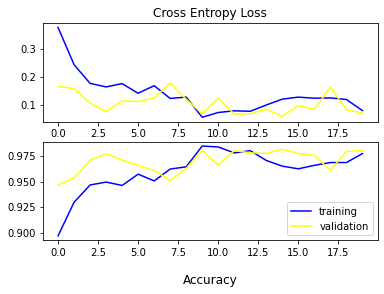

In [4]:
best_model.save('CNN_realsense_2', save_format='h5') 

from keras.utils import to_categorical 

Y_train_realsense = to_categorical(Y_train_realsense, dtype='float32') 
Y_val_realsense = to_categorical(Y_val_realsense, dtype='float32') 
Y_test_realsense = to_categorical(Y_test_realsense, dtype='float32') 


# Running model on training data 
best_model.compile(optimizer='Adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                   metrics=['accuracy']) 

history = best_model.fit(X_train_realsense, Y_train_realsense, epochs=20, batch_size=64, validation_data=(X_val_realsense, Y_val_realsense))

# Retrieving loss function 

def summarize_diagnostics(history):
    # loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='yellow', label='validation')

    # accuracy
    plt.subplot(212)
    plt.title('Accuracy', y=-0.5)
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='yellow', label='validation')
    plt.legend(['training', 'validation'])
    plt.show()

summarize_diagnostics(history)

99/99 - 0s - loss: 0.0741 - accuracy: 0.9803 - 242ms/epoch - 2ms/step
0.07413822412490845 0.9803174734115601
99/99 [==============================] - 0s 1ms/step


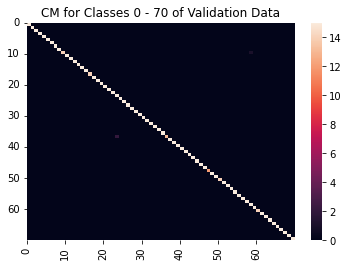

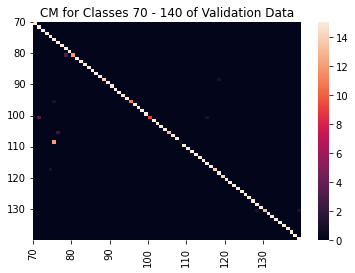

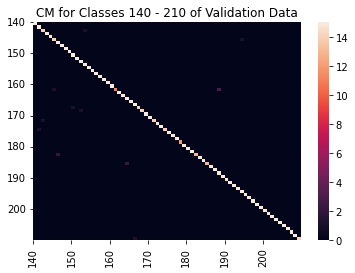

99/99 [==============================] - 0s 2ms/step


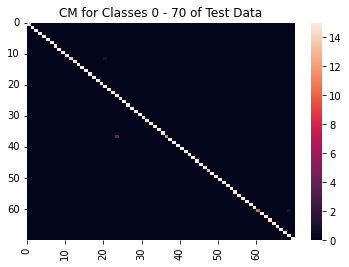

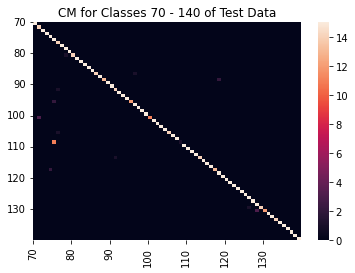

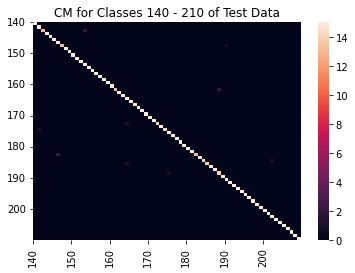

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        15
           1    1.00000   1.00000   1.00000        15
           2    1.00000   1.00000   1.00000        15
           3    1.00000   1.00000   1.00000        15
           4    1.00000   1.00000   1.00000        15
           5    1.00000   1.00000   1.00000        15
           6    1.00000   1.00000   1.00000        15
           7    1.00000   1.00000   1.00000        15
           8    1.00000   1.00000   1.00000        15
           9    1.00000   1.00000   1.00000        15
          10    1.00000   1.00000   1.00000        15
          11    1.00000   0.93333   0.96552        15
          12    1.00000   1.00000   1.00000        15
          13    1.00000   1.00000   1.00000        15
          14    1.00000   1.00000   1.00000        15
          15    1.00000   1.00000   1.00000        15
          16    1.00000   1.00000   1.00000        15
          17    1.00000   1

In [7]:
# Importing libraries
import tensorflow as tf
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sbn
import itertools

# Loading data
def load_images():
    X_train_realsense = pickle.load(open('X_train_realsense.pkl', 'rb'))
    X_val_realsense = pickle.load(open('X_val_realsense.pkl', 'rb'))
    X_test_realsense = pickle.load(open('X_test_realsense.pkl', 'rb'))
    return X_train_realsense, X_val_realsense, X_test_realsense

X_train_realsense, X_val_realsense, X_test_realsense = load_images()

def load_labels():
    Y_train_realsense = pickle.load(open('Y_train_realsense.pkl', 'rb'))
    Y_val_realsense = pickle.load(open('Y_val_realsense.pkl', 'rb'))
    Y_test_realsense = pickle.load(open('Y_test_realsense.pkl', 'rb'))
    return Y_train_realsense, Y_val_realsense, Y_test_realsense

Y_train_realsense, Y_val_realsense, Y_test_realsense = load_labels()


# Loading model

loss, accuracy = best_model.evaluate(X_test_realsense, Y_test_realsense, verbose=2)
print(loss, accuracy) 

# Confusion Matrices for Validation Data

# Make label from one-hot encoding for confusion matrices
Y_train_realsense = np.argmax(Y_train_realsense, axis=1)
Y_val_realsense = np.argmax(Y_val_realsense, axis=1)
Y_test_realsense = np. argmax(Y_test_realsense, axis=1)


predictions_val_realsense = best_model.predict(X_val_realsense)
pred_val_labels_realsense = np.argmax(predictions_val_realsense, axis=1)

CM1_1 = confusion_matrix(Y_val_realsense, pred_val_labels_realsense, labels=np.arange(0,70))
ax = plt.axes()
sbn.heatmap(CM1_1, annot=False,
            annot_kws = {"size":10},
            xticklabels = np.arange(0,70,10),
            yticklabels = np.arange(0,70,10), ax = ax),
ax.set_title("CM for Classes 0 - 70 of Validation Data")
plt.xticks(ticks=np.arange(0,70,10), labels=np.arange(0,70,10))
plt.yticks(ticks=np.arange(0,70,10), labels=np.arange(0,70,10))
plt.show()

CM1_2 = confusion_matrix(Y_val_realsense, pred_val_labels_realsense, labels=np.arange(70,140))
ax = plt.axes()
sbn.heatmap(CM1_2, annot=False,
            annot_kws = {"size":10},
            xticklabels = np.arange(70,140,10),
            yticklabels = np.arange(70,140,10), ax=ax),
ax.set_title("CM for Classes 70 - 140 of Validation Data")
plt.xticks(ticks=np.arange(0,70,10), labels=np.arange(70,140,10))
plt.yticks(ticks=np.arange(0,70,10), labels=np.arange(70,140,10))
plt.show()

CM1_3 = confusion_matrix(Y_val_realsense, pred_val_labels_realsense, labels = np.arange(140, 210))
ax = plt.axes()
sbn.heatmap(CM1_3, annot=False,
            annot_kws = {"size":10},
            xticklabels = np.arange(140,210,10),
            yticklabels = np.arange(140,210,10), ax = ax),
ax.set_title("CM for Classes 140 - 210 of Validation Data")
plt.xticks(ticks=np.arange(0,70,10), labels=np.arange(140,210,10))
plt.yticks(ticks=np.arange(0,70,10), labels=np.arange(140,210,10))
plt.show()


# Confusion Matrix for Test Data

predictions_test_realsense = best_model.predict(X_test_realsense)
pred_test_labels_realsense = np.argmax(predictions_test_realsense, axis=1)

CM2_1 = confusion_matrix(Y_test_realsense, pred_test_labels_realsense, labels = np.arange(0,70))
ax = plt.axes()
sbn.heatmap(CM2_1, annot=False,
            annot_kws={"size":10},
            xticklabels=np.arange(0,70,10),
            yticklabels=np.arange(0,70,10), ax=ax)
ax.set_title("CM for Classes 0 - 70 of Test Data")
plt.xticks(ticks=np.arange(0,70,10), labels=np.arange(0,70,10))
plt.yticks(ticks=np.arange(0,70,10), labels=np.arange(0,70,10))
plt.show()

CM2_2 = confusion_matrix(Y_test_realsense, pred_test_labels_realsense, labels = np.arange(70,140))
ax = plt.axes()
sbn.heatmap(CM2_2, annot=False,
            annot_kws={"size":10},
            xticklabels = np.arange(70,140,10),
            yticklabels = np.arange(70,140,10), ax=ax)
ax.set_title("CM for Classes 70 - 140 of Test Data")
plt.xticks(ticks=np.arange(0,70,10), labels=np.arange(70,140,10))
plt.yticks(ticks=np.arange(0,70,10), labels=np.arange(70,140,10))
plt.show()

CM2_3 = confusion_matrix(Y_test_realsense, pred_test_labels_realsense, labels = np.arange(140,210))
ax = plt.axes()
sbn.heatmap(CM2_3, annot=False,
            annot_kws={"size":10},
            xticklabels = np.arange(140,210,10),
            yticklabels = np.arange(140,210,10), ax = ax)
ax.set_title("CM for Classes 140 - 210 of Test Data")
plt.xticks(ticks=np.arange(0,70,10), labels=np.arange(140,210,10))
plt.yticks(ticks=np.arange(0,70,10), labels=np.arange(140,210,10))
plt.show()

report_test = classification_report(Y_test_realsense, pred_test_labels_realsense, digits=5)
print(report_test) 